# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [7]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [8]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

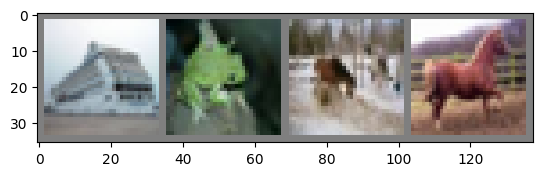

ship frog horse horse


In [9]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [10]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.conv_residual = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=8)
        self.linear = nn.Linear(512, n_classes)



    def forward(self, x):
        y = self.conv_residual(x)
        x = self.block(x)
        x = x + y
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        out = self.linear(x)
        return out

In [11]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_residual): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
torch.cuda.is_available()

True

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [17]:
criterion = nn.CrossEntropyLoss()

In [14]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        # <your code here>
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            predictions = model(data)
            loss = nn.CrossEntropyLoss()(predictions, target)
        loss_log.append(loss.item())

        # <your code here>
        acc = torch.sum((predictions.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.sum(acc_log) / len(loader.dataset)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        # <your code here>
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        predictions = model(data)
        loss = nn.CrossEntropyLoss()(predictions, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        # <your code here>
        acc = torch.sum((predictions.argmax(dim=1) == target).to(torch.float32))
        acc_log.append(acc.item()) 

    return np.mean(loss_log), np.sum(acc_log) / len(train_loader.dataset)

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4591524863591796, train acc: 0.48228571428571426
 val loss: 1.1967941002642855, val acc: 0.5785333333333333

Epoch 1
 train loss: 1.1497615289208658, train acc: 0.5982285714285714
 val loss: 1.145742533815668, val acc: 0.6059333333333333

Epoch 2
 train loss: 1.0381038357832315, train acc: 0.6392571428571429
 val loss: 1.0755441703694932, val acc: 0.6299333333333333

Epoch 3
 train loss: 0.9848274648516444, train acc: 0.6587428571428572
 val loss: 1.0503219693265062, val acc: 0.6395333333333333

Epoch 4
 train loss: 0.9526150333380132, train acc: 0.6708285714285714
 val loss: 0.9616120414530978, val acc: 0.6646

Epoch 5
 train loss: 0.929552763646002, train acc: 0.6766285714285715
 val loss: 0.9488025959501876, val acc: 0.6738

Epoch 6
 train loss: 0.898449345524176, train acc: 0.6872
 val loss: 1.0450005582038393, val acc: 0.6507333333333334

Epoch 7
 train loss: 0.8818622739267088, train acc: 0.6933714285714285
 val loss: 0.97555350090595, val acc: 0.6679333333

Посчитайте точность на тестовой выборке:

In [14]:
# <your code here>
test_loss_log, test_acc_log = test(net, test_loader)
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Accuracy на тестовой выборке: 0.6929, Loss на тестовой выборке: 0.8977138210254111


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [15]:
# <your code here>
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, color='g', label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, color='r', label='validation')
    axs[0].set_ylabel('loss')
    axs[0].set_xticks(range(1, 21))

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, color='g', label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, color='r', label='validation')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xticks(range(1, 21))

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

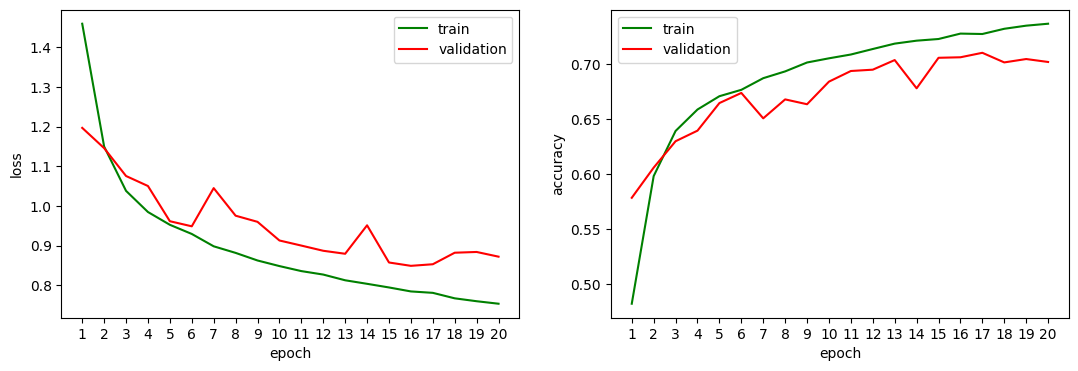

In [16]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4759432104649448, train acc: 0.4729714285714286
 val loss: 1.3505389847653977, val acc: 0.5347333333333333

Epoch 1
 train loss: 1.175265622204357, train acc: 0.5882857142857143
 val loss: 1.1652394025883777, val acc: 0.5933333333333334

Epoch 2
 train loss: 1.0671975596295413, train acc: 0.6282
 val loss: 1.2055098173466134, val acc: 0.5856666666666667

Epoch 3
 train loss: 0.9984958726483681, train acc: 0.6540857142857143
 val loss: 1.0067744196729458, val acc: 0.6505333333333333

Epoch 4
 train loss: 0.9578124698816749, train acc: 0.6681428571428571
 val loss: 0.9972115468471608, val acc: 0.6503333333333333

Epoch 5
 train loss: 0.9263238291199944, train acc: 0.6804857142857142
 val loss: 0.9865829173554765, val acc: 0.6582

Epoch 6
 train loss: 0.9039071432742166, train acc: 0.6851714285714285
 val loss: 0.9426328489120971, val acc: 0.6764666666666667

Epoch 7
 train loss: 0.8830855006055814, train acc: 0.6932
 val loss: 0.9391806432541381, val acc: 0.6784666

Посчитайте точность на тестовой выборке:

In [18]:
# <your code here>
test_loss_log, test_acc_log = test(net, test_loader)
print('MultiStepLR:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

MultiStepLR:
Accuracy на тестовой выборке: 0.7204, Loss на тестовой выборке: 0.827219012056946


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [20]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8337009155772068, train acc: 0.35882857142857144
 val loss: 1.6025960323658395, val acc: 0.44826666666666665

Epoch 1
 train loss: 1.53031085723061, train acc: 0.4622857142857143
 val loss: 1.4461215952609447, val acc: 0.4958

Epoch 2
 train loss: 1.4136893570532092, train acc: 0.5034857142857143
 val loss: 1.3611653789560845, val acc: 0.5205333333333333

Epoch 3
 train loss: 1.3398011088153343, train acc: 0.5297142857142857
 val loss: 1.312809309046319, val acc: 0.5378

Epoch 4
 train loss: 1.2800190193779508, train acc: 0.5518571428571428
 val loss: 1.2645274370274646, val acc: 0.5568

Epoch 5
 train loss: 1.230892517122098, train acc: 0.5696571428571429
 val loss: 1.2068332661973669, val acc: 0.5787333333333333

Epoch 6
 train loss: 1.1905640503170285, train acc: 0.5835714285714285
 val loss: 1.1730926432508104, val acc: 0.5901333333333333

Epoch 7
 train loss: 1.1517580829329204, train acc: 0.5989428571428571
 val loss: 1.136809187239789, val acc: 0.605866666

In [21]:
test_loss_log, test_acc_log = test(net, test_loader)
print('Константный Learning rate:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Константный Learning rate:
Accuracy на тестовой выборке: 0.667, Loss на тестовой выборке: 0.9578968389019086


Качество действительно получилось хуже..

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Посмотрел на разные шедулеры в документации и вот [тут](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling)

1. MultiplicativeLR: умножаем LR каждой группы параметров на коэффициент лямбда.

In [22]:
# <your code here>
# MultiplicativeLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)


test_loss_log, test_acc_log = test(net, test_loader)
print('MultiplicativeLR:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Epoch 0
 train loss: 1.4681961495000222, train acc: 0.47905714285714285
 val loss: 1.2406876688307904, val acc: 0.57

Epoch 1
 train loss: 1.136357964937604, train acc: 0.6020285714285715
 val loss: 1.1426259758624624, val acc: 0.5970666666666666

Epoch 2
 train loss: 0.99649890478176, train acc: 0.6542857142857142
 val loss: 1.065130697159057, val acc: 0.6289333333333333

Epoch 3
 train loss: 0.9282440362290447, train acc: 0.6780285714285714
 val loss: 0.9558985492016406, val acc: 0.6686666666666666

Epoch 4
 train loss: 0.9017721745824029, train acc: 0.688
 val loss: 0.9420670514411115, val acc: 0.6724666666666667

Epoch 5
 train loss: 0.8943038977260346, train acc: 0.6916285714285715
 val loss: 0.9394822536630834, val acc: 0.6729333333333334

Epoch 6
 train loss: 0.8932131503792088, train acc: 0.6915428571428571
 val loss: 0.9399828149917278, val acc: 0.6715333333333333

Epoch 7
 train loss: 0.8932322288779934, train acc: 0.6919142857142857
 val loss: 0.9396734684071643, val acc: 0.

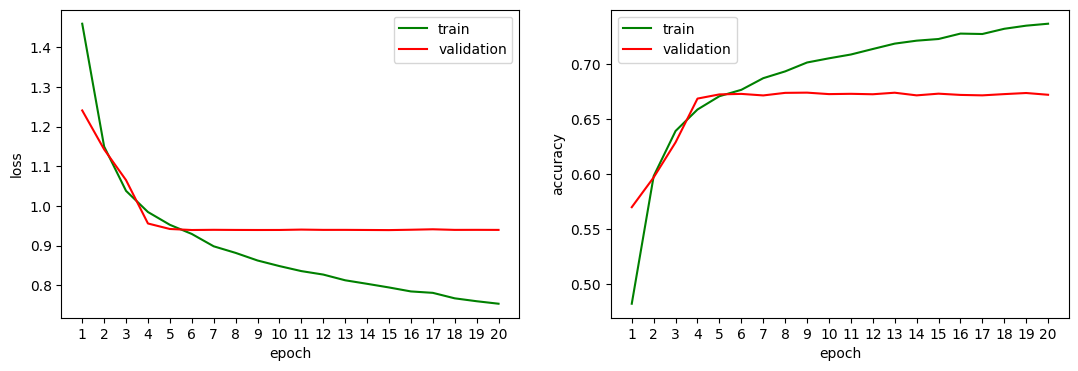

In [24]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

2. ExponentialLR: Уменьшает LR каждой группы параметров на гамму каждую эпоху. Когда last_epoch=-1, устанавливает начальный lr.

In [25]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss_log, test_acc_log = test(net, test_loader)
print('ExponentialLR:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Epoch 0
 train loss: 1.4533531138404414, train acc: 0.48137142857142856
 val loss: 1.26107705730073, val acc: 0.5665333333333333

Epoch 1
 train loss: 1.0483950982364048, train acc: 0.6348285714285714
 val loss: 1.039269121149753, val acc: 0.6371333333333333

Epoch 2
 train loss: 0.9926430656007701, train acc: 0.6544857142857143
 val loss: 1.007489418476186, val acc: 0.6487333333333334

Epoch 3
 train loss: 0.985542609116277, train acc: 0.657
 val loss: 1.0071974564105906, val acc: 0.6502

Epoch 4
 train loss: 0.9852410328235661, train acc: 0.6560571428571429
 val loss: 1.0065824605048972, val acc: 0.6486

Epoch 5
 train loss: 0.9848806499563144, train acc: 0.6564857142857143
 val loss: 1.006910036472564, val acc: 0.6501333333333333

Epoch 6
 train loss: 0.9848815229954624, train acc: 0.6560857142857143
 val loss: 1.0065432733677804, val acc: 0.6488

Epoch 7
 train loss: 0.9846708128395638, train acc: 0.6559428571428572
 val loss: 1.0065373856970605, val acc: 0.6482666666666667

Epoch 

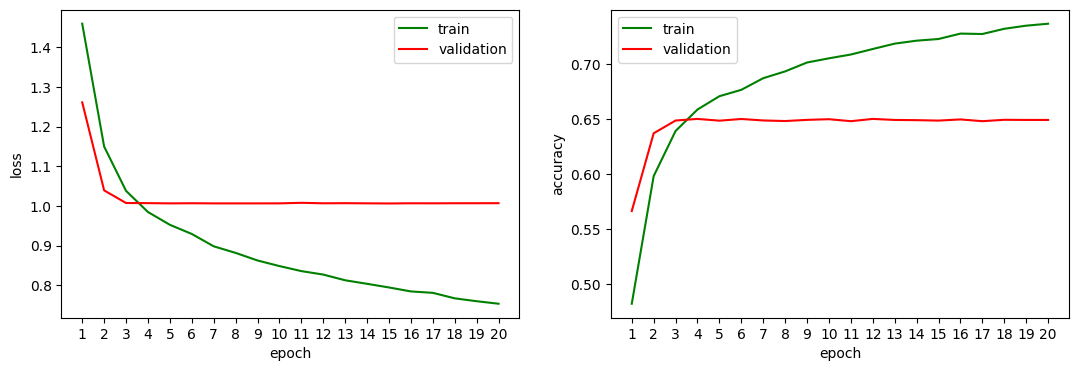

In [26]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

3. Cosine Annealing Warm Restarts: Выбираем LR каждой группы параметров, используя график косинусного отжига, и перезапукаем после прохождения Ti эпох.

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

test_loss_log, test_acc_log = test(net, test_loader)
print('CosineAnnealingWarmRestarts:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Epoch 0
 train loss: 1.5092729811694547, train acc: 0.4614285714285714
 val loss: 1.3149216920771498, val acc: 0.5294

Epoch 1
 train loss: 1.1986238836588328, train acc: 0.5778857142857143
 val loss: 1.1389611936630086, val acc: 0.5996

Epoch 2
 train loss: 1.068533387110046, train acc: 0.6283428571428571
 val loss: 1.076568556085546, val acc: 0.6227333333333334

Epoch 3
 train loss: 0.9880516442999762, train acc: 0.6593142857142857
 val loss: 1.0286179786032819, val acc: 0.6446

Epoch 4
 train loss: 0.9296884793903971, train acc: 0.6801142857142857
 val loss: 0.9496903924231833, val acc: 0.6724

Epoch 5
 train loss: 0.8837140648195033, train acc: 0.6927428571428571
 val loss: 0.9112950649667293, val acc: 0.6862

Epoch 6
 train loss: 0.8446584881114786, train acc: 0.7090571428571428
 val loss: 0.8926884303701684, val acc: 0.6957333333333333

Epoch 7
 train loss: 0.8059904743701056, train acc: 0.7219714285714286
 val loss: 0.8838332594709194, val acc: 0.6946

Epoch 8
 train loss: 0.778

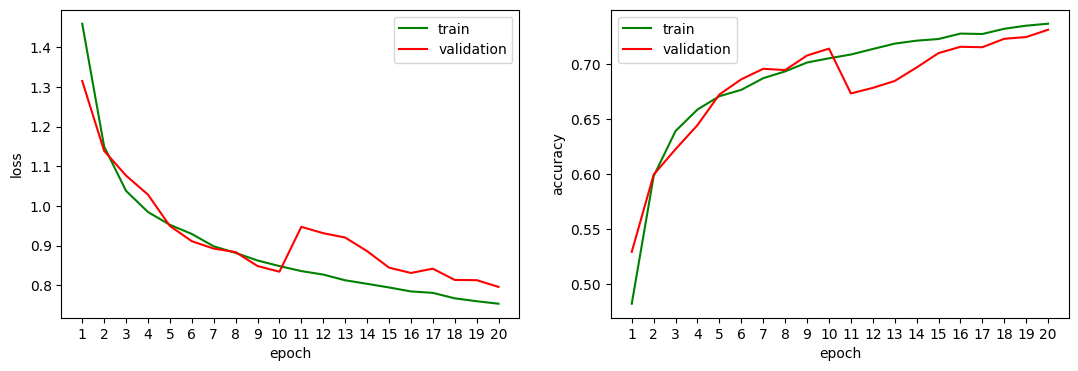

In [28]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Тут в какой-то момент видимо началось переобучение, т.к. аккураси резко упало, а лосс вырос

Your answers here: Accuracy улучшить не удалось :( 

Я посмотрел на форуме, выбранный в задании MultiStepLR шедулер как раз используется очень даже часто. 

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

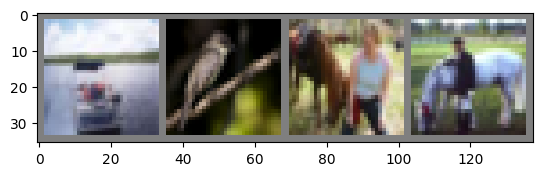

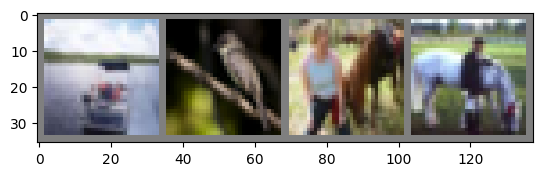

In [29]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [30]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4809228615525436, train acc: 0.4732
 val loss: 1.274684961045042, val acc: 0.5468

Epoch 1
 train loss: 1.1793832894435095, train acc: 0.5865714285714285
 val loss: 1.089405209460157, val acc: 0.6209333333333333

Epoch 2
 train loss: 1.0566269092847487, train acc: 0.6305142857142857
 val loss: 1.0748263085142096, val acc: 0.6249333333333333

Epoch 3
 train loss: 0.9993457456393477, train acc: 0.6537428571428572
 val loss: 0.9759586090737201, val acc: 0.6607333333333333

Epoch 4
 train loss: 0.9636049887379955, train acc: 0.6636571428571428
 val loss: 0.9803099409062812, val acc: 0.6544666666666666

Epoch 5
 train loss: 0.922078610992083, train acc: 0.6786857142857143
 val loss: 0.9377173106721107, val acc: 0.6698

Epoch 6
 train loss: 0.9082690329176852, train acc: 0.6871714285714285
 val loss: 0.9542363526973319, val acc: 0.6682

Epoch 7
 train loss: 0.8921620299327961, train acc: 0.6908

Посчитайте точность на тестовой выборке:

In [31]:
# <your code here>
test_loss_log, test_acc_log = test(net, test_loader)
print('Аугментации, горизонтальные повороты:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Аугментации, горизонтальные повороты:
Accuracy на тестовой выборке: 0.7272, Loss на тестовой выборке: 0.7933314702693065


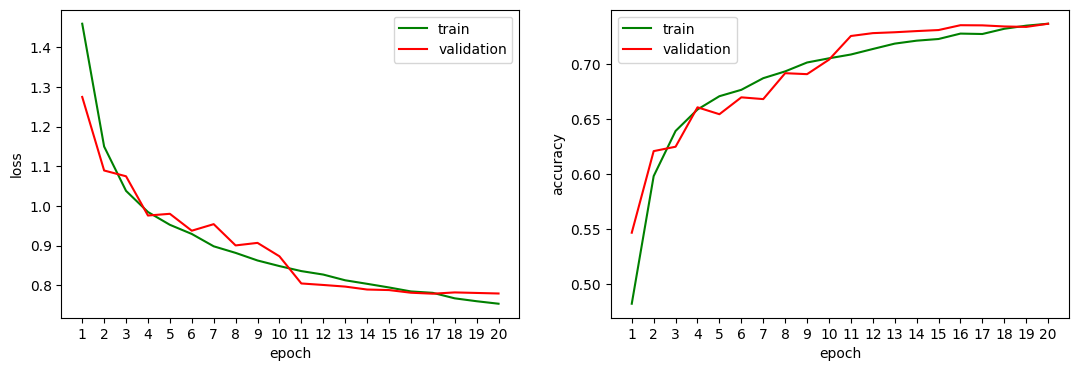

In [32]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Вертикальный флип

In [41]:
# <your code here>
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.643762442268009, train acc: 0.40305714285714284
 val loss: 1.4616905770403275, val acc: 0.46986666666666665

Epoch 1
 train loss: 1.3817301753234166, train acc: 0.5078285714285714
 val loss: 1.3040743812601616, val acc: 0.5372

Epoch 2
 train loss: 1.2707348812432786, train acc: 0.5488285714285714
 val loss: 1.1978526407099785, val acc: 0.5761333333333334

Epoch 3
 train loss: 1.2121509271086461, train acc: 0.5693714285714285
 val loss: 1.199441829133541, val acc: 0.5800666666666666

Epoch 4
 train loss: 1.1671165162510149, train acc: 0.5867714285714286
 val loss: 1.2041624680478522, val acc: 0.5745333333333333

Epoch 5
 train loss: 1.1314939272469098, train acc: 0.5987714285714286
 val loss: 1.182262135566549, val acc: 0.5797333333333333

Epoch 6
 train loss: 1.1084507686346496, train acc: 0.6100571428571429
 val loss: 1.1550914396630956, val acc: 0.588

Epoch 7
 train loss: 1.0965754852

In [42]:
test_loss_log, test_acc_log = test(net, test_loader)
print('Аугментации, вертикальные повороты:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Аугментации, горизонтальные повороты:
Accuracy на тестовой выборке: 0.6575, Loss на тестовой выборке: 0.9710153739923125


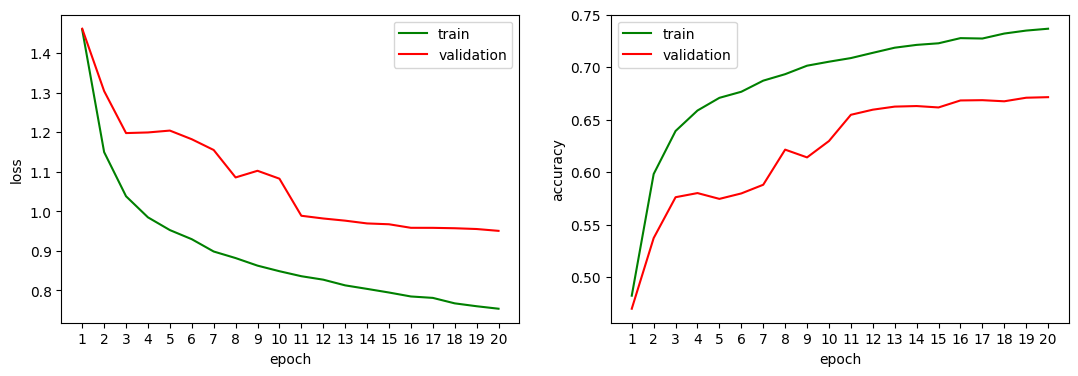

In [43]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Вертикальный флип плохо себя показывает на тестовой выборке, не будем его использовать

Рандомное изменение яркости, контрастности, насыщенности и оттенка изображения

In [44]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4893267641773607, train acc: 0.46854285714285715
 val loss: 1.2874626801369038, val acc: 0.5353333333333333

Epoch 1
 train loss: 1.1755034943167426, train acc: 0.5896
 val loss: 1.100994521759926, val acc: 0.6195333333333334

Epoch 2
 train loss: 1.055680348406762, train acc: 0.6311714285714286
 val loss: 1.031305285463942, val acc: 0.6497333333333334

Epoch 3
 train loss: 0.9948857008212227, train acc: 0.6532571428571429
 val loss: 1.0038047539426926, val acc: 0.6530666666666667

Epoch 4
 train loss: 0.9523491778800867, train acc: 0.6668285714285714
 val loss: 1.0087675320341232, val acc: 0.6481333333333333

Epoch 5
 train loss: 0.920070168849973, train acc: 0.6792571428571429
 val loss: 1.0165067335392566, val acc: 0.6478666666666667

Epoch 6
 train loss: 0.8982328305078817, train acc: 0.6868857142857143
 val loss: 1.0104770556409308, val acc: 0.6445333333333333

Epoch 7
 train loss: 0

In [47]:
test_loss_log, test_acc_log = test(net, test_loader)
print('Аугментации, цвет и интенсивность:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Аугментации, цвет и интенсивность:
Accuracy на тестовой выборке: 0.7193, Loss на тестовой выборке: 0.8221890945343455


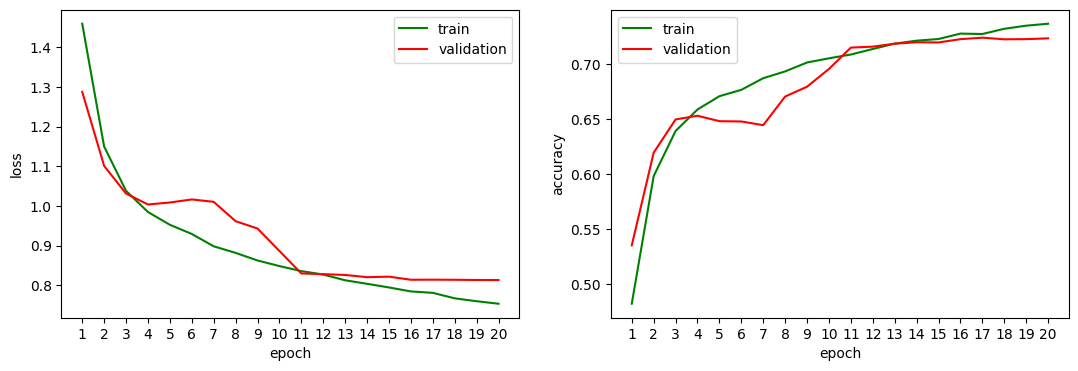

In [46]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Случайный ресайз изображения с возвращением к итоговому разрешению

In [49]:
transform = transforms.Compose(
        [transforms.RandomResizedCrop(size=(32, 32)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.8414351351736233, train acc: 0.3318
 val loss: 1.7205035635765562, val acc: 0.37706666666666666

Epoch 1
 train loss: 1.696545597404187, train acc: 0.3859142857142857
 val loss: 1.6221455376198952, val acc: 0.4196666666666667

Epoch 2
 train loss: 1.609731708845665, train acc: 0.42328571428571427
 val loss: 1.564116082292922, val acc: 0.4448

Epoch 3
 train loss: 1.5479076287864113, train acc: 0.4480857142857143
 val loss: 1.670373272895813, val acc: 0.42493333333333333

Epoch 4
 train loss: 1.5178077863818766, train acc: 0.45754285714285714
 val loss: 1.5756141535779262, val acc: 0.4446

Epoch 5
 train loss: 1.4943947613348254, train acc: 0.4672857142857143
 val loss: 1.4953736761783032, val acc: 0.46873333333333334

Epoch 6
 train loss: 1.4778783674431892, train acc: 0.4704285714285714
 val loss: 1.457402780208182, val acc: 0.4854

Epoch 7
 train loss: 1.4620854973357165, train acc: 0.4

In [53]:
test_loss_log, test_acc_log = test(net, test_loader)
print('Аугментации, кроп ресайз:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Аугментации, кроп ресайз:
Accuracy на тестовой выборке: 0.6315, Loss на тестовой выборке: 1.058369451267704


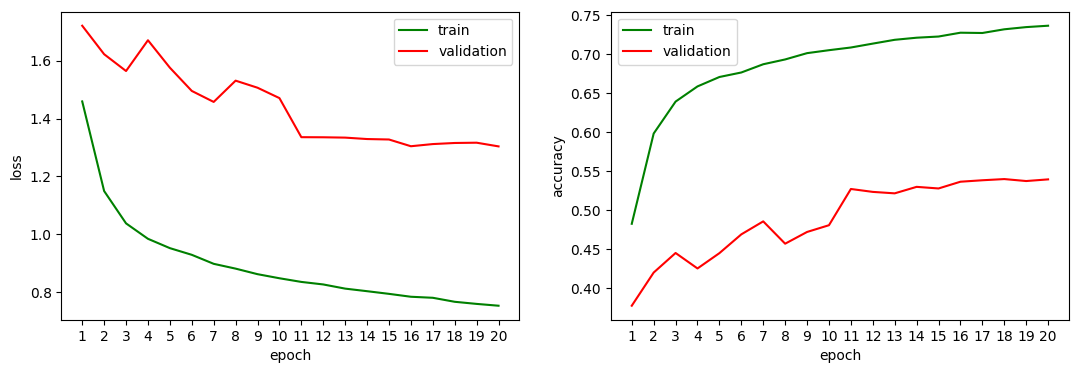

In [51]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Результат на тестовой выборке плохой, не будем использовать

Применяем лучшие: горизонтальный своп и смену цвета\интенсивности 

In [54]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.502688330749707, train acc: 0.4649714285714286
 val loss: 1.2856655029540367, val acc: 0.5393333333333333

Epoch 1
 train loss: 1.1920560157059314, train acc: 0.5818285714285715
 val loss: 1.0812989059914935, val acc: 0.6220666666666667

Epoch 2
 train loss: 1.0616412676012712, train acc: 0.6305142857142857
 val loss: 1.016748733977054, val acc: 0.6546666666666666

Epoch 3
 train loss: 1.0023025818019289, train acc: 0.6520285714285714
 val loss: 0.9846484785384321, val acc: 0.6616

Epoch 4
 train loss: 0.9636633786248551, train acc: 0.6652285714285714
 val loss: 1.0559066744560892, val acc: 0.6314666666666666

Epoch 5
 train loss: 0.931167170814012, train acc: 0.6783714285714286
 val loss: 0.9569069286610218, val acc: 0.6659333333333334

Epoch 6
 train loss: 0.9145071423685747, train acc: 0.6835428571428571
 val loss: 0.9591840893664259, val acc: 0.6671333333333334

Epoch 7
 train loss: 0

In [55]:
test_loss_log, test_acc_log = test(net, test_loader)
print('Аугментации, лучшие:')
print(f'Accuracy на тестовой выборке: {test_acc_log}, Loss на тестовой выборке: {test_loss_log}')

Аугментации, лучшие:
Accuracy на тестовой выборке: 0.7268, Loss на тестовой выборке: 0.7955171834131715


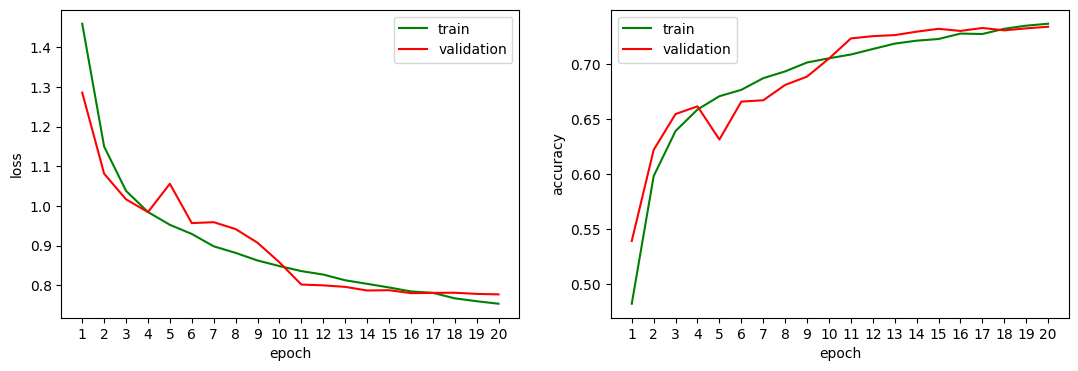

In [56]:
plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)

Your answers here: На тестовой выборке лучше всего себя показала аугментация с горизонтальным свопом, при этом добавление смены цвета\интенсивности результат только ухудшило.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Логинимся

In [1]:
!pip install wandb -qU


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# <your code here>
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Midnight Commander\.netrc


True

In [3]:
config = {
  "dataset": "CIFAR10",
  'WANDB_NOTEBOOK_NAME': 'Gleb',
  "model": "BaseBlockNet",
  "learning_rate": 0.1,
  "batch_size": 64,
}

Переделываем функцию обучения под wandb

In [15]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        metrics = {
            "train loss": train_loss, 
            "val loss": val_loss,
            "train acc": train_acc, 
            "val acc": val_acc,
        }

        wandb.log(metrics)

        print(f"Epoch {epoch}")
        print(f" train loss: {train_loss}, train acc: {train_acc}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [20]:
net = BasicBlockNet().to(device)
wandb.init(
    project="HW2-Basic",
    config=config
)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
wandb.finish()

train acc,▁▅▇▇███████████
train loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▁▇████████████
val loss,██▂▁▁▁▁▁▁▁▁▁▁▁▁
train acc,0.69803
train loss,0.87966
val acc,0.682
val loss,0.91911


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002011A8B5F80>
Traceback (most recent call last):
  File "c:\Users\Midnight Commander\Documents\Study\DL\intro-to-dl-hse\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\Midnight Commander\Documents\Study\DL\intro-to-dl-hse\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 0
 train loss: 1.5119772277758805, train acc: 0.46154285714285714
 val loss: 1.3114110414018023, val acc: 0.5370666666666667

Epoch 1
 train loss: 1.188694819126966, train acc: 0.5822571428571428
 val loss: 1.1583474806014529, val acc: 0.5984666666666667

Epoch 2
 train loss: 1.0640517789223511, train acc: 0.6282285714285715
 val loss: 1.0564684304785221, val acc: 0.6368666666666667

Epoch 3
 train loss: 0.9988528543460086, train acc: 0.6508571428571429
 val loss: 1.0285511848774362, val acc: 0.6522666666666667

Epoch 4
 train loss: 0.9545494189428019, train acc: 0.6689428571428572
 val loss: 0.9589445015217396, val acc: 0.672

Epoch 5
 train loss: 0.9262472955574719, train acc: 0.6789142857142857
 val loss: 0.9839952674317867, val acc: 0.662

Epoch 6
 train loss: 0.9030818116512334, train acc: 0.6884285714285714
 val loss: 0.9650489804592538, val acc: 0.6691333333333334

Epoch 7
 train loss: 0.882749648046232, train acc: 0.6947142857142857
 val loss: 0.9430325147953439, val acc:

train acc,▁▄▅▆▆▇▇▇▇▇▇▇▇███████
train loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val acc,▁▄▅▆▇▆▆▇▆▇▇▇▇▇▇▇████
val loss,█▆▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▁
train acc,0.73486
train loss,0.76467
val acc,0.70573
val loss,0.85791


[Ссылка на графики](https://api.wandb.ai/links/hse1/id1rt505)